In [1]:
# Current test dataset scrape and load works, but not to build a sufficient model 

    # select and narrow down input features for model
        # features from live dataset:
            # [1] order size
            # [2] time (may not be used or extremely difficult to factor in)
        # potential calcuated features to be added alongside input:
            # [3] order position from execution point/"spread"
            # [4] order size delta from last update
        # potential features from additional API input:    
            # [5] extract candlestick data for the last hour or 15 minutes
                # calc overall slope/trend for that hour
                # factor in support and resistance points for candles with long wicks for that hour
                    # establish those zones as potential breakpoints
                    # as current price approaches those breakpoints, weight size more in model     
                # Use TA-lib wrapper to auto establish support and resistance zones for the 15 minute/1 hour chart
                    # (https://github.com/mrjbq7/ta-lib)
            # [6] severe hashrate changes  ("https://blockchain.info/q/hashrate")
                # if hashrate for total network has sharp change down, buy walls likely to encouter less resistance
                # assumed negative correlation
                # put in range to prevent small changes from overinfluencing model
            # [7] severe unconfirmed tx ("https://blockchain.info/q/unconfirmedcount")
                # similar to [6], except that with sharp increase up, sell walls likely to encouter less resistance
                # assumed positive correlation
                # put in range to prevent small changes from overinfluencing model

        # Calculate orderbook states from L2 updates
            # pick interval between applying l2update to last updated snapshot
            # 5 minutes, 15 minutes
            
    # Model selection
        # Supervised = feature[x1,x2,x3....], target[y]
            # features[x] --> variables with predictive power

            # Supervised (output value or label is known)
                # 1D CNN/2D (position and size of orderbook)
                # LSTM/GRU
                    # regression vs classification example difference : 
                        #predicting price as value over time vs. price direction over time
                         
        # Reinforcement learning ---> categorial cross entropy of likelyhood that this "wall" is STRONG or WEAK
            # i.e. supported or not suppported; don't know exactly outcome [y]
                # but still able to predict an assumed categorical class class []
                    
###########################
        
        # UPDATE CYCLE: EVERY 15 MINUTES 
            # [position,size,size delta]
                #features= [position,size,size delta]
                    # algorithm sets y variable labels based upon prexisting historical data 
                    # logistic classification: [strong, weak, fake, real]
                        # "known relationship" -> identify class that the data belongs 
                        # Technically pseudo-labeling/semi-supervised learning approach ##
            # set [y] variable to true or scale from 0-1 for all orders near key S/R areas for past 15 min
                # TA-lib library + numpy + pandas = should be able to do this
         
        # pull websocket l2/snapshot data + candlesticks for past 15 minutes
            # apply scale or label to l2 
                # scale updated upon position change or next l2 update (15 minute sync)
                
                
###########################

###Model design
        # model = Sequential()
    ###INPUT LAYER
                                    ## [samples,timesteps,features] ##
                                    # samples = data rows
                                    # timesteps
                                        # How long in time each sample is; 
                                            # if feeding in 15 minutes, then 15 ticks?
                                            # 5 minutes may be more practical
                                    # features = features
            
        # model.add(LSTM(2))
        # model.add(Dense(1))
    ###OUTPUT LAYER
        # Softmax activation 
        # One node per class value if one hot encodedinput         
            
            

In [2]:
# Imports
import pandas as pd
import numpy as np
import json
import datetime 
import matplotlib.pyplot as plt
%matplotlib inline

# Charting-specific imports
import matplotlib.finance
import matplotlib.ticker as mticker
from matplotlib.finance import candlestick_ohlc,candlestick2_ohlc
from matplotlib.finance import volume_overlay,volume_overlay2
from matplotlib.dates import  DateFormatter, epoch2num
# https://matplotlib.org/api/finance_api.html#module-matplotlib.finance

import requests
import gdax

# Pymongo import for connection to local client DB
import pymongo
from pymongo import MongoClient

# Preprocessing Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler,OneHotEncoder
from keras.utils import to_categorical 

# ML Imports 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from keras.layers import LSTM, GRU
from keras.models import load_model
from keras import backend as K

#num_cores = 4
#config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        #inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        #device_count = {'CPU' : 1, 'GPU' : 1})
#session = tf.Session(config=config)
#K.set_session(session)


# Import to check check for GPU availability for tensorflow backend
from tensorflow.python.client import device_lib


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Historic rates 15 minute basis example
# Build 15 minute chart from this data - time series olhc&vol data

public_client = gdax.PublicClient()
chart_1hr =public_client.get_product_historic_rates('BTC-USD', granularity=3600) 
chart_15m =public_client.get_product_historic_rates('BTC-USD', granularity=900)
    # 900 seconds = 15 minutes,  # 3600 seconds = 1 hour
    # Potentially compare to 6h/1d as overall reference for uptrend/downtrend short term
    # Structure of response: 
        # [ time, low, high, open, close, volume ]
        
    # Pass start and end date/time as unix timestamp for past hour
    # Dates in unix/ISO_8601 format: https://en.wikipedia.org/wiki/ISO_8601

In [4]:
# Convert chart data response into dataframes
chart_1hr_df =pd.DataFrame.from_records(chart_1hr,columns=["time","low", "high","open" ,  "close", "volume"])
chart_15m_df =pd.DataFrame.from_records(chart_15m,columns=["time","low", "high","open" ,  "close", "volume"])

In [5]:
# Current hashrate and unconfirmed TX from blockchain.info
    # limit quests to a maximum of 1 every 10 seconds.
# Estimated hashrate in gigahash
response = requests.get("https://blockchain.info/q/hashrate")
print(response.json())
# Number of pending unconfirmed transactions
response2 = requests.get("https://blockchain.info/q/unconfirmedcount")
print(response2.json())

29200582171
2979


In [6]:
# start/end time from request log
request_log_df= pd.read_csv("test_data/request_log.csv")
print(request_log_df.head())

      Unnamed: 0                       iso         epoch
0    request end  2018-04-17T01:05:03.469Z  1.523927e+09
1  request start  2018-04-17T00:55:03.354Z  1.523927e+09


In [7]:
chart_15m_df.head()

,time,low,high,open,close,volume
0,1524107580,8189.33,8189.34,8189.34,8189.34,0.198251
1,1524107520,8183.00,8189.34,8183.01,8189.34,2.224707
2,1524107460,8183.01,8187.93,8184.00,8183.01,6.519576
3,1524107400,8176.67,8183.00,8179.98,8183.00,14.452026
4,1524107340,8179.97,8182.34,8182.34,8179.97,17.301240


In [8]:
chart_15m_df = chart_15m_df[["time","open","high","low","close","volume"]]
chart_15m_df.head()

,time,open,high,low,close,volume
0,1524107580,8189.34,8189.34,8189.33,8189.34,0.198251
1,1524107520,8183.01,8189.34,8183.00,8189.34,2.224707
2,1524107460,8184.00,8187.93,8183.01,8183.01,6.519576
3,1524107400,8179.98,8183.00,8176.67,8183.00,14.452026
4,1524107340,8182.34,8182.34,8179.97,8179.97,17.301240


In [9]:
chart_15m_df['time'] =pd.to_datetime(chart_15m_df['time'],unit='s')
chart_15m_df.head()

,time,open,high,low,close,volume
0,2018-04-19 03:13:00,8189.34,8189.34,8189.33,8189.34,0.198251
1,2018-04-19 03:12:00,8183.01,8189.34,8183.00,8189.34,2.224707
2,2018-04-19 03:11:00,8184.00,8187.93,8183.01,8183.01,6.519576
3,2018-04-19 03:10:00,8179.98,8183.00,8176.67,8183.00,14.452026
4,2018-04-19 03:09:00,8182.34,8182.34,8179.97,8179.97,17.301240


In [10]:
# Auto support/resistance adapted into function
    # Source: Adapted from https://github.com/nakulnayyar/SupResGenerator
from pandas_datareader import data, wb
from sklearn.cluster import MeanShift, estimate_bandwidth

def autoSR(dataframe):
    data = chart_15m_df.as_matrix(columns=['close'])
    data2 = data[:len(data)*1]
    bandwidth = estimate_bandwidth(data2, quantile=0.1, n_samples=100)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(data2)
    ml_results = []
    for k in range(len(np.unique(ms.labels_))):
            my_members = ms.labels_ == k
            values = data[my_members, 0]    
            ml_results.append(min(values))
            ml_results.append(max(values))
    return ml_results

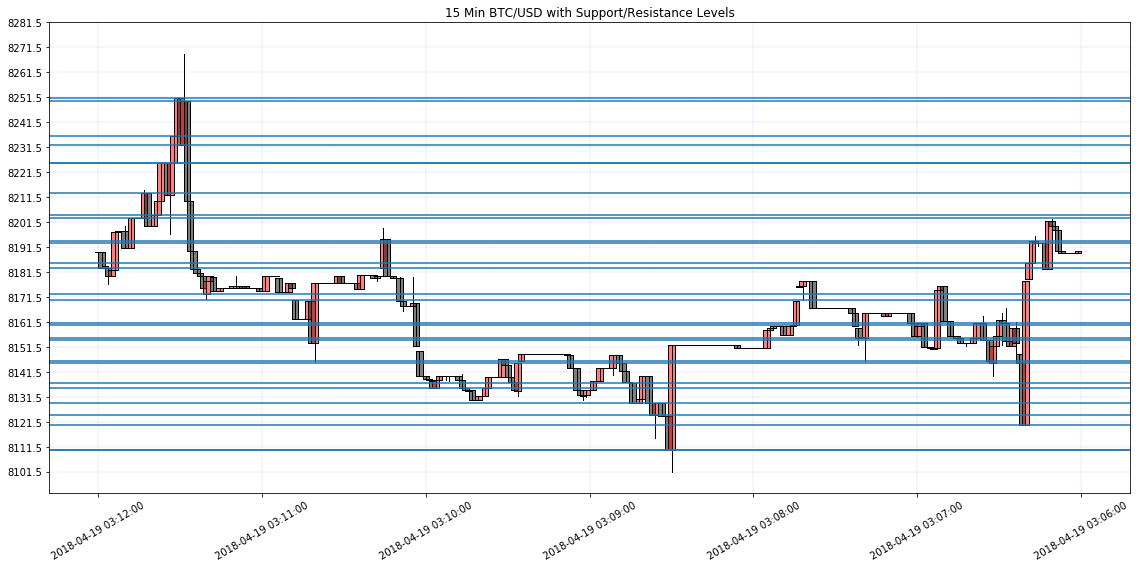

In [11]:
# Generate chart of past 15 minutes with autogenerated support and resistance levels:
fig, ax = plt.subplots(figsize=(16, 8)
                     )
candlestick2_ohlc(ax,chart_15m_df['open'],chart_15m_df['high'],chart_15m_df['low'],chart_15m_df['close'],width=2,\
                  colorup='k',colordown='r',alpha=.5)
ax.set_xticklabels(chart_15m_df['time'] ,rotation=30)
plt.yticks(np.arange(min(chart_15m_df['low']), max(chart_15m_df['high'])+20, 10))
#ax.minorticks_on()
ax.set_axisbelow(True)
ax.grid(which='major', linestyle='--', linewidth='0.1', color='b')
matplotlib.pyplot.title("15 Min BTC/USD with Support/Resistance Levels")
#volume_overlay2(chart_15m_df['close'],chart_15m_df['volume'],width=1,colorup='k',colordown='r',alpha=1)
ml_results = autoSR(chart_15m_df)
for k in ml_results:
    plt.axhline(y=k)
plt.tight_layout()
plt.show()

In [73]:
print("Auto generated support and resistance levels for past 15 minutes:")
print(ml_results)

Auto generated support and resistance levels for past 15 minutes:
[8146.0, 8154.15, 8172.79, 8183.01, 8161.0, 8170.16, 8136.99, 8145.0, 8154.96, 8160.11, 8128.95, 8135.01, 8185.25, 8193.12, 8194.0, 8203.11, 8204.44, 8213.02, 8120.31, 8123.99, 8224.99, 8225.01, 8232.42, 8236.1, 8249.88, 8251.04, 8109.97, 8109.97]


In [88]:
snapshot_asks_df = pd.read_csv("test_data/snapshot_asks.csv")
snapshot_bids_df = pd.read_csv("test_data/snapshot_bids.csv")
l2update_df = pd.read_csv("test_data/l2update.csv", dtype ={'changes':object})
request_log_df= pd.read_csv("test_data/request_log.csv")
snapshot_both_df = pd.concat([snapshot_asks_df,snapshot_bids_df], axis=0, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True)

In [89]:
# Test add of features as columnsto dataset

# Set inital size delta l2 snapshot
snapshot_asks_df['size_delta'] = 0
snapshot_bids_df['size_delta'] = 0
# Set inital position for l2 snapshot
snapshot_asks_df['position'] = snapshot_asks_df.index +1
snapshot_bids_df['position'] = snapshot_bids_df.index +1
# Reverse index for sell/asks
#napshot_asks_df =snapshot_asks_df[::-1]
# Reverse inital position indicator for bids/buy side
rev = snapshot_bids_df['position'].values * -1
snapshot_bids_df['position'] = rev

In [90]:
snapshot_asks_df.tail()

,side,price,size,size_delta,position
16992,sell,6.794720e+09,0.000174,0,16993
16993,sell,9.719374e+09,0.001000,0,16994
16994,sell,9.987654e+09,0.001049,0,16995
16995,sell,1.000000e+10,0.014000,0,16996
16996,sell,1.000000e+10,0.028392,0,16997


In [91]:
snapshot_bids_df.head()

,side,price,size,size_delta,position
0,buy,8042.90,9.118009,0,-1
1,buy,8042.83,0.002487,0,-2
2,buy,8042.50,0.420000,0,-3
3,buy,8042.00,0.001000,0,-4
4,buy,8041.33,0.020000,0,-5


In [78]:
# Autogenerated support/resistance past 15 minutes
print("Auto generated support and resistance levels for past 15 minutes:")
print(ml_results)

Auto generated support and resistance levels for past 15 minutes:
[8146.0, 8154.15, 8172.79, 8183.01, 8161.0, 8170.16, 8136.99, 8145.0, 8154.96, 8160.11, 8128.95, 8135.01, 8185.25, 8193.12, 8194.0, 8203.11, 8204.44, 8213.02, 8120.31, 8123.99, 8224.99, 8225.01, 8232.42, 8236.1, 8249.88, 8251.04, 8109.97, 8109.97]


In [102]:
# Set inital proximity to autogenerated S/R levels
snapshot_asks_df['sr_proximity'] = 0 
snapshot_bids_df['sr_proximity'] = 0

In [92]:
# Convert ml_results into sorted int array
ml_results_modified =np.asarray(ml_results)
ml_results_modified =np.trunc(ml_results_modified).astype(int)
ml_results_modified = np.sort(ml_results_modified,kind = 'quicksort') 
ml_results_modified 

array([8109, 8109, 8120, 8123, 8128, 8135, 8136, 8145, 8146, 8154, 8154,
       8160, 8161, 8170, 8172, 8183, 8185, 8193, 8194, 8203, 8204, 8213,
       8224, 8225, 8232, 8236, 8249, 8251])

In [112]:
# Set inital proximity feature for l2 snapshot within +30/-30 range
#snapshot_asks_df =snapshot_asks_df[::-1]
for i in range(len(snapshot_asks_df['price'])):
    if snapshot_asks_df['price'].values[i] in ml_results_modified:
        #print(snapshot_asks_df['price'].values[i])
        snapshot_asks_df['sr_proximity'].values[i] =1
    if snapshot_asks_df['price'].values[i] in ml_results_modified-10:
        snapshot_asks_df['sr_proximity'].values[i] = -1
    if snapshot_asks_df['price'].values[i] in ml_results_modified+10:
        snapshot_asks_df['sr_proximity'].values[i] = 2
    if snapshot_asks_df['price'].values[i] in ml_results_modified-20:
        snapshot_asks_df['sr_proximity'].values[i] = -2
    if snapshot_asks_df['price'].values[i] in ml_results_modified+20:
        snapshot_asks_df['sr_proximity'].values[i] = 3
    if snapshot_asks_df['price'].values[i] in ml_results_modified-30:
        snapshot_asks_df['sr_proximity'].values[i] = -3
    if snapshot_asks_df['price'].values[i] in ml_results_modified+30:
        snapshot_asks_df['sr_proximity'].values[i] = 4 
for i in range(len(snapshot_bids_df['price'])):
    if snapshot_bids_df['price'].values[i] in ml_results_modified:
        #print(snapshot_bids_df['price'].values[i])
        snapshot_bids_df['sr_proximity'].values[i] =1    
    if snapshot_bids_df['price'].values[i] in ml_results_modified-10:
        snapshot_bids_df['sr_proximity'].values[i] = -1
    if snapshot_bids_df['price'].values[i] in ml_results_modified+10:
        snapshot_bids_df['sr_proximity'].values[i] = 2
    if snapshot_bids_df['price'].values[i] in ml_results_modified-20:
        snapshot_bids_df['sr_proximity'].values[i] = -2
    if snapshot_bids_df['price'].values[i] in ml_results_modified+20:
        snapshot_bids_df['sr_proximity'].values[i] = 3
    if snapshot_bids_df['price'].values[i] in ml_results_modified-30:
        snapshot_bids_df['sr_proximity'].values[i] = -3
    if snapshot_bids_df['price'].values[i] in ml_results_modified+30:
        snapshot_bids_df['sr_proximity'].values[i] = 4   
     

In [118]:
# Check to make sure proximity set worked
snapshot_asks_df.loc[snapshot_asks_df['sr_proximity'] == 1]

,side,price,size,size_delta,position,sr_proximity
306,sell,8109.0,0.001000,0,307,1
351,sell,8120.0,0.596669,0,352,1
364,sell,8123.0,0.001000,0,365,1
383,sell,8128.0,0.251000,0,384,1
501,sell,8154.0,0.001000,0,502,1
533,sell,8161.0,0.001000,0,534,1
582,sell,8172.0,0.001000,0,583,1
634,sell,8185.0,0.002000,0,635,1
771,sell,8225.0,0.887974,0,772,1
796,sell,8232.0,0.001000,0,797,1
